In [11]:
import numpy as np
import pandas as pd
import fiona
import geopandas as gpd
import os
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [12]:
# data import
dataDir = r"C:\Users\DUANYUEYUN\Documents\ArcGIS\Projects\WHO_ISS"
df_iss = gpd.read_file(dataDir+"\\WHO_ISS.gdb", driver='FileGDB', 
                       layer= 'ISS_1020')
dataDir = r"C:\Users\DUANYUEYUN\Documents\GRID3\Health facilities\Data\Africa\Cleaned"
filename = "clean_names_types_1109.csv"
path = os.path.join(dataDir, filename)
new_cols = pd.read_csv(path)

In [13]:
# reformat the date column
df_iss['date'] = pd.to_datetime(df_iss['date_of_visit'])
# get index
df_iss.reset_index(inplace=True)
# merge with new columns including 'clean_name_final'
df_iss = df_iss.merge(new_cols, on='index')

In [14]:
df_iss.shape

(305182, 51)

# Define functions

In [20]:
def find_subclusters(df, name='Name', clean_name='Short_Name',
                     cluster='FEAT_SEQ', date='date', fac_type='type',
                     simple_score=80, simple_score_min=50, 
                     partial_score=80, partial_score2=90):
    """
    Obtain subclusters: data points within 1km, matched to the same name and have the same facility type.
    """
    
    # if the cleaned short name is NA, just use original facility name instead
    names = []
    for idx, row in df.iterrows():
        if isinstance(row[clean_name], str):
            names.append(row[clean_name])
        else:
            names.append(row[name])
    df['name_for_matching'] = names 
    df['name_for_matching'].fillna('NA', inplace=True)
    
    # sort values based on feature sequence and short name
    df.sort_values(by=[cluster, 'name_for_matching', date], inplace=True)
    # group by feature sequence
    df_grouped = df.groupby(cluster)

    # store the matched name
    match_names = []
    # store count of subclusters
    sub_counts = []
    # store score of matching
    match_scores = []
    # store types of matching
    match_types = []

    for group_name, df_group in df_grouped:
        # obtain list of names
        names = df_group['name_for_matching'].to_list()
        
        # use the first name as the potential candidates for finding a match
        match_candidates = [names[0]]
        match_names.append(names[0])
        match_scores.append(np.nan)
        match_types.append('Self')

        for i in range(1, len(names)):

            name = names[i]

            # use match candidates to find best match and compute match score
            match_name1, score1 = process.extractOne(name, match_candidates, scorer = fuzz.ratio)
            match_name2, score2 = process.extractOne(name, match_candidates, scorer = fuzz.partial_ratio)

            # score based on simple ratio
            # or for very short strings, a single letter difference will result in low score
            # consider two short strings as a match if there's only 1 letter difference
            if score1>=simple_score or (1-score1/100) * len(name) <= 1:
                # append match name and score
                match_names.append(match_name1)
                match_scores.append(score1)
                match_types.append('Simple match')

            # if simple ratio not that high, check partial ratio
            elif score1>=simple_score_min and score2>=partial_score:
                # append match name and score
                match_names.append(match_name2)
                match_scores.append(score2)
                match_types.append('Partial match')

            elif score1>=simple_score_min:
                # check scores again after sorting the letters in names individually
                match_candidates2 = [''.join(sorted(candidate)) for candidate in match_candidates]
                match_name3, score3 = process.extractOne(''.join(sorted(name)), match_candidates2, 
                                                         scorer = fuzz.ratio)
                match_name4, score4 = process.extractOne(''.join(sorted(name)), match_candidates2, 
                                                         scorer = fuzz.partial_ratio)

                # or for very short strings, a single letter difference will result in low score
                # consider two short strings as a match if there's only 1 letter difference
                if score3>=simple_score or (1-score3/100) * len(name) <= 1:
                    # append match name and score
                    index = match_candidates2.index(match_name3)
                    match_names.append(match_candidates[index])
                    match_scores.append(score3)
                    match_types.append('Sorted simple match')

                # if simple ratio not that high, check partial ratio
                elif score3>=simple_score_min and score4>=partial_score2:
                    # append match name and score
                    index = match_candidates2.index(match_name4)
                    match_names.append(match_candidates[index])
                    match_scores.append(score4)
                    match_types.append('Sorted partial match')

                # if nothing above works, add the name to match candidates
                else:
                    match_candidates.append(name)
                    match_names.append(name)
                    match_scores.append(np.nan)
                    match_types.append('Self')

            # the match score based on simple ratio is lower than the minimum required
            # just match the name to itself and add it to match candidates
            else:
                match_candidates.append(name)
                match_names.append(name)
                match_scores.append(np.nan)
                match_types.append('Self')

        for i in range(len(names)):
            sub_counts.append(len(match_candidates))
    
    df['match_name'] = match_names
    df['n_subclusters'] = sub_counts
    df['match_score'] = match_scores
    df['match_type'] = match_types
    
    def rank(s):
        return s.rank(method='dense')
    
    # assign a sub sequence number
    df['name_seq'] = df.groupby(cluster)['match_name'].apply(rank)
    df['name_seq'].fillna(0, inplace=True)
    
    df['type_seq'] = df.groupby([cluster, 'name_seq'])[fac_type].apply(rank)
    df['type_seq'].fillna(0, inplace=True)
    
    # generate cluster ID
    df['clusterID'] = pd.Series(df[cluster]*100000+df['name_seq']*100+df['type_seq']) 
    
    df.sort_values(by=['clusterID'], inplace=True)
    
    return df

In [16]:
def cal_cluster_ratio(df, clusterID='clusterID', cluster='FEAT_SEQ',
                      date = 'date'):
    """
    Calculate cluster ratio after fuzzy match.
    """
    # obtain cluster size
    counts = df.groupby(cluster).size()
    counts = pd.DataFrame({'freq_count':counts})
    counts.reset_index(inplace=True)
    # join back to the original dataframe
    df = df.merge(counts, on =[cluster])

    res = df.groupby(['FEAT_SEQ','name_seq','type_seq'])\
    .agg(cluster_size=('freq_count', 'max'), subcluster_size=('freq_count','count'))
    res['cluster_ratio'] = res['subcluster_size']/res['cluster_size']
    res.reset_index(inplace=True)
    df = df.merge(res, on=['FEAT_SEQ','name_seq','type_seq'])
    df = df.sort_values(by=['FEAT_SEQ','name_seq','type_seq', 'cluster_ratio', date])
    
    return df

In [34]:
def eval_points(df, cluster = 'FEAT_SEQ', cluster_size = 'cluster_size', 
                subcluster_size = 'subcluster_size',
                num_subclusters = 'n_subclusters', ratio = 'cluster_ratio',
               new_col='eval'):
    """Implement a decision tree to evalute subclusters and create an `eval` column.
    Possible values include 0 (to be dropped), 1 (good point to be kept) and
    2 (point that needs further examination)
    """

    evaluation = []

    clusters = df.groupby(cluster)

    for group_name, group_df in clusters:

        # number of points in the cluster
        N = group_df[cluster_size].iloc[0]
        # number of subclusters within the cluster
        m = group_df[num_subclusters].iloc[0]

        # Single point clusters
        if N==1:
            evaluation.append(2)

        # Two point clusters
        elif N==2:
            for idx, row in group_df.iterrows():
                # two points agree
                if row[ratio]==1:
                    evaluation.append(1)
                else:
                    evaluation.append(2)

        elif N==3:
            for idx, row in group_df.iterrows():
                # keep points with ratio >= 2/3, further evaluate the remaining points
                if row[ratio]>0.66:
                    evaluation.append(1)
                else:
                    evaluation.append(2)   

        elif N==4:
            # every point disagrees
            if m==4:
                for idx, row in group_df.iterrows():
                    evaluation.append(2)
            else:
                for idx, row in group_df.iterrows():
                    # keep points with ratio greater than or equal to 0.5
                    if row[ratio]>=0.5:
                        evaluation.append(1)
                    else:
                        evaluation.append(0)
        # cluster size greater than 4
        else:
            for idx, row in group_df.iterrows():
                if row[ratio]<=0.2:
                    evaluation.append(0)
                elif row[ratio]>0.2 and row[ratio]<0.5:
                    evaluation.append(2)
                else:
                    evaluation.append(1)

    df[new_col] = evaluation     
    return df

In [35]:
def drop_points(df, decision = 'eval', clusterID = 'clusterID'):
    """Drop subclusters with eval of 0,
    keep the last point in subclusters with eval of 1 or 2.
    decision: column name that contains evaluation of points."""
    
    df = df[df[decision]!=0]
    
    df_dropped = df.drop_duplicates(subset=[clusterID], keep='last')
    
    return df_dropped

## 1st round cleaning

In [21]:
# find subclusters
iss_processed = find_subclusters(df_iss, name='clean_name', clean_name='clean_name_final', 
                                 date='date', cluster='FEAT_SEQ',
                                 fac_type='type_of_facility_visited',
                                 simple_score=80, simple_score_min=50, 
                                 partial_score=80, partial_score2=90)

In [22]:
print("Number of subclusters:", iss_processed['clusterID'].nunique())

Number of subclusters: 92665


In [23]:
# calculate cluster ratio
iss_ratio = cal_cluster_ratio(iss_processed)

In [31]:
cols = ['Country', 'clean_name_final', 'type_of_facility_visited', 'match_name',
        'FEAT_SEQ', 'clusterID', 'cluster_size', 'subcluster_size', 'cluster_ratio']
iss_ratio[iss_ratio['FEAT_SEQ']==9][cols]

,Country,clean_name_final,type_of_facility_visited,match_name,FEAT_SEQ,clusterID,cluster_size,subcluster_size,cluster_ratio
71,ANGOLA,Damba,DISTRICT_HOSP,Damba,9,900101.0,5,5,1.0
70,ANGOLA,Damba,DISTRICT_HOSP,Damba,9,900101.0,5,5,1.0
69,ANGOLA,Damba,DISTRICT_HOSP,Damba,9,900101.0,5,5,1.0
68,ANGOLA,Damba,DISTRICT_HOSP,Damba,9,900101.0,5,5,1.0
67,ANGOLA,Damba,DISTRICT_HOSP,Damba,9,900101.0,5,5,1.0


Text(0.5, 1.0, 'ISS: histogram of cluster ratio')

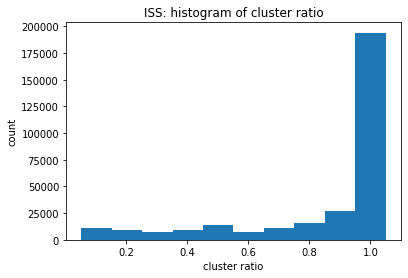

In [32]:
f = plt.hist(iss_ratio['cluster_ratio'], bins=10, align='right')
plt.xlabel('cluster ratio')
plt.ylabel('count')
plt.title('ISS: histogram of cluster ratio')

In [33]:
iss_ratio['cluster_ratio'].describe()

count    305182.000000
mean          0.825142
std           0.272227
min           0.004405
25%           0.759259
50%           0.972973
75%           1.000000
max           1.000000
Name: cluster_ratio, dtype: float64

In [36]:
# evaluate points
iss_decision = eval_points(iss_ratio, cluster='FEAT_SEQ') 

In [37]:
iss_decision['eval'].value_counts(sort=False)

0     21311
1    222461
2     61410
Name: eval, dtype: int64

In [38]:
iss_dropped = drop_points(iss_decision)

In [39]:
print("Number of data points at start:", df_iss.shape[0])
print("Number of data points after dropping:", df_iss.shape[0]-iss_dropped.shape[0])

Number of data points at start: 305182
Number of data points after dropping: 227938


In [40]:
iss_dropped['geometry'] = iss_dropped['geometry'].to_crs(epsg=4326)
iss_dropped['x_coor'] = iss_dropped['geometry'].x
iss_dropped['y_coor'] = iss_dropped['geometry'].y

In [49]:
cols = ['Country', 'clean_name_final', 'type_of_facility_visited', 'match_name',
        'FEAT_SEQ', 'clusterID', 'cluster_size', 'subcluster_size', 'cluster_ratio',
       'eval']
iss_decision[iss_decision['FEAT_SEQ']==47][cols]

,Country,clean_name_final,type_of_facility_visited,match_name,FEAT_SEQ,clusterID,cluster_size,subcluster_size,cluster_ratio,eval
182,ANGOLA,Andulo,CSI,Andulo,47,4700101.0,5,1,0.2,0
183,ANGOLA,Andulo,DISTRICT_HOSP,Andulo,47,4700102.0,5,1,0.2,0
184,ANGOLA,NaN,CSI,Cmi,47,4700201.0,5,1,0.2,0
185,ANGOLA,Marteno,CSI,Marteno,47,4700301.0,5,1,0.2,0
186,ANGOLA,NaN,DISTRICT_HOSP,Municipal Hospital,47,4700401.0,5,1,0.2,0


In [41]:
#iss_decision.head()

In [42]:
#iss_dropped.head()

In [50]:
iss_decision.drop(columns=['OBJECTID', 'IN_FID', 'freq_count'],
                 inplace=True)
iss_decision.rename(columns={'index':'index_original', 'FEAT_SEQ':'Cluster_seq'},
                   inplace=True)
iss_decision.reset_index(drop=True,inplace=True)

In [51]:
iss_dropped.drop(columns=['OBJECTID', 'IN_FID', 'freq_count'],
                 inplace=True)
iss_dropped.rename(columns={'index':'index_original', 'FEAT_SEQ':'Cluster_seq'},
                   inplace=True)
iss_dropped.reset_index(drop=True,inplace=True)

In [52]:
# Export results as csv files
dataDir = r"C:\Users\DUANYUEYUN\Documents\GRID3\Health facilities\Data\Africa"
iss_decision.to_csv(dataDir + "\\Cleaned\\iss_decision1_1109.csv",
                      index=False)
iss_dropped.to_csv(dataDir + "\\Cleaned\\iss_dropped1_1109.csv",
                     index=False)

## 2nd round cleaning

Starting from here, points with `eval` of 0 in the first phase are dropped and duplicates within subclusters with `eval` of 1 or 2 are also dropped such that there is only one point representing each subcluster.

A new feature sequence is found using a radius of 1km and a match on `match_name`.

In [53]:
# Data import
dataDir = r"C:\Users\DUANYUEYUN\Documents\GRID3\Health facilities\Data\Africa"
iss_dropped1 = pd.read_csv(dataDir + "\\Cleaned\\iss_dropped1_1109.csv")

C:\Users\DUANYUEYUN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (13,20,24,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
dataDir2 = r"C:\Users\DUANYUEYUN\Documents\ArcGIS\Projects\WHO_ISS"
feat_seq = gpd.read_file(dataDir2+"\\WHO_ISS.gdb", driver='FileGDB', 
                       layer= 'iss_dropped1_1109_FI')

In [55]:
print(iss_dropped1.shape[0])
print(feat_seq.shape[0])

77244
77782


In [56]:
feat_seq = feat_seq.sort_values(by=['IN_FID', 'FEAT_SEQ'])\
.drop_duplicates(subset='IN_FID', keep='first')
feat_seq['IN_FID'] = feat_seq['IN_FID']-1
# add feature sequence to original dataset
iss_dropped1 = iss_dropped1.merge(feat_seq.drop(columns=['geometry']), left_index=True, right_on='IN_FID')

In [67]:
#iss_dropped1[iss_dropped1['FEAT_SEQ']==11]

In [59]:
print("Number of data points:", iss_dropped1.shape[0])
print("Number of clusters:", iss_dropped1['FEAT_SEQ'].max())

Number of data points: 77244
Number of clusters: 65447


In [60]:
def eval_phase2(df, cluster='FEAT_SEQ', decision='eval',
               subcluster_size='subcluster_size', new_decision = 'eval2'):
    
    """Evaluate points within the new cluster.
    0 means drop and 1 means keep.
    decision: column name for first phase evaluation.
    new_decision: column name for second phase evaluation."""
    
    drop = []
    df.sort_values([cluster, decision, subcluster_size], inplace=True)
    df_grouped = df.groupby(cluster)
    
    for name, df_group in df_grouped:
        max_subcluster = df_group[subcluster_size].max()
        
        # There are points with both eval=1 and eval=2 in the cluster
        if df_group[decision].nunique()>1:
            # If there are more than 1 point with eval=1, keep the point with max sublcuster size
            if df_group[df_group[decision]==1].shape[0]>1:
                for idx, row in df_group.iterrows():
                    # Keep only points with eval=1
                    if row[decision]==1 and row[subcluster_size]==max_subcluster:
                        drop.append(1)
                    # Drop points with eval=2  
                    else:
                        drop.append(0)
            # There is only 1 point with eval=1, just keep that point and drop the rest
            else:
                for idx, row in df_group.iterrows():
                    # Keep only points with eval=1
                    if row[decision]==1:
                        drop.append(1)
                    # Drop points with eval=2  
                    else:
                        drop.append(0)
        # There are either points with eval=1 or points with eval=2 (exclusive)       
        else:
            for idx, row in df_group.iterrows():
                # Keep only points with the maximum subcluster size
                if row[subcluster_size]==max_subcluster:
                    drop.append(1)
                # Drop all other points   
                else:
                    drop.append(0)
                 
    df[new_decision] = drop
    return df                         

In [61]:
iss_decision2 = eval_phase2(iss_dropped1)

In [62]:
iss_decision2['eval2'].value_counts()

1    68380
0     8864
Name: eval2, dtype: int64

In [63]:
# drop points with eval=0 in second phase cleaning
iss_dropped2 = iss_decision2[iss_decision2['eval2']==1]

In [64]:
iss_decision2.drop(columns=['IN_FID'], inplace=True)
iss_decision2.rename(columns={'FEAT_SEQ':'Cluster_seq2'}, inplace=True)
iss_decision2.reset_index(drop=True, inplace=True)

In [65]:
iss_dropped2.drop(columns=['IN_FID'], inplace=True)
iss_dropped2.rename(columns={'FEAT_SEQ':'Cluster_seq2'}, inplace=True)
iss_dropped.reset_index(drop=True, inplace=True)

In [66]:
iss_decision2.to_csv(dataDir+"\\Cleaned\\iss_decision2_1109.csv",
                   index=False)
iss_dropped2.to_csv(dataDir+"\\Cleaned\\iss_dropped2_1109.csv",
                   index=False)